문장을 입력해서 이진분류하는 모델에 대해서 알아보겠습니다. 언어가 시계열적인 의미가 있으므로, 이 언어를 문자로 표현한 문장도 시계열적인 의미가 있습니다. 

모델에 입력하기 위해서 문장을 시계열수치로 인코딩하는 방법과 이진분류 모델을 구성해보고, 학습 결과를 살펴보겠습니다.

이 모델들은 문장 혹은 시계열수치로 양성/음성을 분류하거나 이벤트 발생 유무를 감지하는 문제를 풀 수 있습니다. 

필요한 패키지를 가져옵니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb

### 데이터셋 준비

IMDB에서 제공하는 영화 리뷰 데이터셋을 이용하겠습니다. 이 데이터셋은 훈련셋 25,000개, 시험셋 25,000개의 샘플을 제공합니다. 라벨은 1과 0으로 좋아요/싫어요로 지정되어 있습니다. 

케라스에서 제공하는 imdb의 load_data() 함수을 이용하면 데이터셋을 쉽게 얻을 수 있습니다. 

데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타냅니다. 모든 단어를 고려할 수 없으므로 빈도수가 높은 단어를 위주로 데이터셋을 생성합니다. 

20,000번째로 많이 사용하는 단어까지만 데이터셋으로 만들고 싶다면, num_words 인자에 20000이라고 지정하면 됩니다. 

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

17473536/17464789 [==============================] - 0s 0us/step


풀어야 할 시험셋이 무엇인지 살펴보겠습니다. x_test을 출력하면 다음과 같습니다.

In [3]:
print(x_test)

[list([1, 591, 202, 14, 31, 6, 717, 10, 10, 18142, 10698, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 15387, 38, 32, 25, 7944, 451, 202, 14, 6, 717])
 list([1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 2679, 23, 1310, 5, 109, 943, 4, 114, 9, 55, 606, 5, 111, 7, 4, 139, 193, 273, 23, 4, 172, 270, 11, 7216, 10626, 4, 8463, 2801, 109, 1603, 21, 4, 22, 3861, 8, 6, 1193, 1330, 10, 10, 4, 105, 987, 35, 841, 16873, 19, 861, 1074, 5, 1987, 17975, 45, 55, 221, 15, 670, 5304, 526, 14, 1069, 4, 405, 5, 2438, 7, 27, 85, 108, 131, 4, 5045, 5304, 3884, 405, 9, 3523, 133, 5, 50, 13, 104, 51, 66, 166, 14, 22, 157, 9, 4, 530, 239, 34, 8463, 2801, 45, 407, 31, 7, 41, 3778, 105, 21, 59, 299, 12, 38, 950, 5, 4521, 15, 45, 629, 488, 2733, 127, 6, 52, 292, 17, 4, 6936, 185, 132, 1988, 5304, 1799, 488, 2693, 47, 6, 392, 173, 4, 2, 4378, 270, 2352, 4

데이터셋의 형태를 확인해봅니다.

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


총 25000개의 샘플이 있으며, 각 샘플은 영화 리뷰 한 건을 의미하며, 단어의 인덱스로 구성되어 있습니다. 'num_words=20000'으로 지정했기 때문에 빈도수가 20,000을 넘는 단어는 보이지가 않습니다.

리뷰의 길이가 다르니 각 샘플의 길이가 다르겠죠? 적개는 수십 단어로 많게는 천 개 이상의 단어로 구성되어 있습니다. 모델의 입력으로 사용하려면 고정된 길이로 만들어야 하므로 케라스에서 제공되는 전처리 함수인 sequence의 pad_sequences() 함수를 사용합니다. 이 함수는 두 가지 역할을 수행합니다. 
* 문장을 maxlen 인자로 지정된 길이로 맞춰줍니다. 예를 들어 200으로 지정했다면 200보다 짧은 문장은 0으로 채워서 200단어로 맞춰주고 200보다 긴 문장은 200단어까지만 잘라냅니다.
* (num_samples, num_timesteps)으로 2차원의 numpy 배열로 만들어줍니다. maxlen을 200으로 지정하였다면, num_timesteps도 200이 됩니다.

In [7]:
from keras.preprocessing import sequence

x_train = sequence.pad_sequences(x_train, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

Using TensorFlow backend.


#### 다층퍼셉트론 신경망 모델

임베딩(Embedding) 레이어로 단어들을 인코딩한 후 Dense 레이어를 통해 분류하는 다층퍼셉트론 신경망 모델입니다. 임베딩 레이어의 인자 의미는 다음과 같습니다.
* 첫번째 인자(input_dim) : 단어 사전의 크기를 말하며 총 20,000개의 단어 종류가 있다는 의미입니다. 이 값은 앞서 imdb.load_data() 함수의 num_words 인자값과 동일해야 합니다. 
* 두번째 인자(output_dim) : 단어를 인코딩 한 후 나오는 벡터 크기 입니다. 이 값이 128이라면 단어를 128차원의 의미론적 기하공간에 나타낸다는 의미입니다. 단순하게 빈도수만으로 단어를 표시한다면, 10과 11은 빈도수는 비슷하지만 단어로 볼 때는 전혀 다른 의미를 가지고 있습니다. 하지만 의미론적 기하공간에서는 거리가 가까운 두 단어는 의미도 유사합니다. 즉 임베딩 레이어는 입력되는 단어를 의미론적으로 잘 설계된 공간에 위치시켜 벡터로 수치화 시킨다고 볼 수 있습니다.
* input_length : 단어의 수 즉 문장의 길이를 나타냅니다. 임베딩 레이어의 출력 크기는 샘플 수 * output_dim * input_lenth가 됩니다. 임베딩 레이어 다음에 Flatten 레이어가 온다면 반드시 input_lenth를 지정해야 합니다. 플래튼 레이어인 경우 입력 크기가 알아야 이를 1차원으로 만들어서 Dense 레이어에 전달할 수 있기 때문입니다.

In [8]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=200))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

네트워크 아키텍처를 정의했으니, 컴파일 후 학습을 시킵니다.

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, epochs=5, batch_size=64, 
                 validation_split=0.2, 
                 callbacks=[checkpoint_callback])

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 30s 1ms/sample - loss: 0.4158 - accuracy: 0.7918 - val_loss: 0.3078 - val_accuracy: 0.8678
Epoch 2/5
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.0479 - accuracy: 0.9837 - val_loss: 0.4456 - val_accuracy: 0.8544
Epoch 3/5
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.5482 - val_accuracy: 0.8564
Epoch 4/5
20000/20000 [==============================] - 28s 1ms/sample - loss: 1.8534e-04 - accuracy: 1.0000 - val_loss: 0.5731 - val_accuracy: 0.8564
Epoch 5/5
20000/20000 [==============================] - 27s 1ms/sample - loss: 9.8346e-05 - accuracy: 1.0000 - val_loss: 0.5911 - val_accuracy: 0.8570


학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 오버피팅 여부를 한 눈에 확인할 수 있습니다.

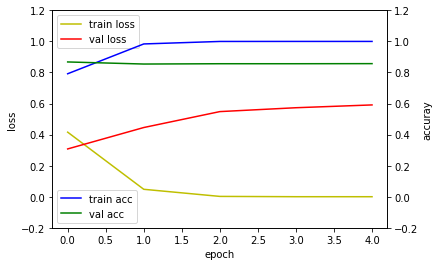

In [10]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

파일로 저장된 모델을 로딩하여 시험셋으로 최종 평가를 수행합니다.

In [11]:
model = load_model("best_model.h5")

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 5s 209us/sample - loss: 0.3104 - accuracy: 0.8666
## evaluation loss and_metrics ##
[0.3104177753973007, 0.86656]


#### 순환 신경망 모델

문장을 단어들의 시퀀스로 간주하고 순환(LSTM) 레이어의 입력으로 구성한 모델입니다. 임베딩 레이어 다음에 LSTM 레이어가 오는 경우에는 임베딩 레이어에 input_length 인자를 따로 설정할 필요는 없습니다. 입력 문장의 길이에 따라 input_length가 자동으로 정해지고, 이것이 LSTM 레이어에는 timesteps으로 입력되기 때문입니다. 블록으로 표현한다면 예제에서는 문장의 길이가 200 단어이므로, LSTM 블록 200개가 이어져있다고 생각하면 됩니다. 

In [13]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

네트워크 아키텍처를 정의했으니, 컴파일 후 학습을 시킵니다.

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, epochs=5, batch_size=64, 
                 validation_split=0.2, 
                 callbacks=[checkpoint_callback])

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 131s 7ms/sample - loss: 0.4110 - accuracy: 0.8022 - val_loss: 0.3208 - val_accuracy: 0.8706
Epoch 2/5
20000/20000 [==============================] - 127s 6ms/sample - loss: 0.2248 - accuracy: 0.9147 - val_loss: 0.3770 - val_accuracy: 0.8420
Epoch 3/5
20000/20000 [==============================] - 128s 6ms/sample - loss: 0.1520 - accuracy: 0.9450 - val_loss: 0.3665 - val_accuracy: 0.8656
Epoch 4/5
20000/20000 [==============================] - 126s 6ms/sample - loss: 0.0876 - accuracy: 0.9712 - val_loss: 0.4317 - val_accuracy: 0.8644
Epoch 5/5
20000/20000 [==============================] - 129s 6ms/sample - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.5352 - val_accuracy: 0.8646


학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 오버피팅 여부를 한 눈에 확인할 수 있습니다.

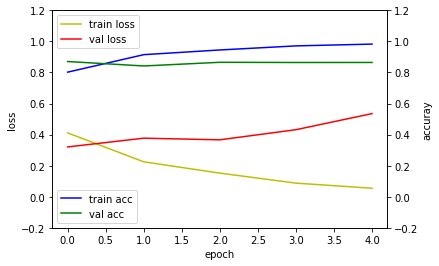

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

파일로 저장된 모델을 로딩하여 시험셋으로 최종 평가를 수행합니다.

In [16]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 56s 2ms/sample - loss: 0.5938 - accuracy: 0.8503
## evaluation loss and_metrics ##
[0.5938358696937561, 0.85032]


또한 시험셋으로 테스트한 결과를 제출하기 위해 모델 결과 파일을 저장합니다. 출력이 0.0과 1.0 사이의 수치를 가진 벡터 하나이므로 0.5를 기준으로 크면 1로, 작으면 0으로 변환하여 이 값을 파일로 저장합니다.

In [17]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
np.savetxt('y_pred.csv', y_pred, fmt='%d')